## Creates binarized Seurat objects, and merges them and finds Top Features (min.cutoff=20)

In [5]:
# Input info
cellr_in = "/data2/isshamie/mito_lineage/data/processed/mtscATAC/DUPI_april08_2021_Croker/MTblacklist_mtasnucl"
#samples = "rxn1,rxn2,rxn3,rxn4"
#sample_names = "preA,preB,postA,postB"

exp = "rxn2"
name = "preA"

# Saving
outdir = "/data/isshamie/mito_lineage/output/annotation/DUPI_april08_2021/MTblacklist_mtasnucl/preA" #"/data2/mito_lineage/Analysis/annotation/output/data/"

# Parameters
nTop = 25000
cores = 36

In [2]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library(future)
plan()

plan("multiprocess", workers = cores)
options(future.globals.maxSize = 8000 * 1024^2)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
#plan("multiprocess", workers = workers)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The follow

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


## Plotting option

In [15]:
library(repr)
options(repr.plot.width=12, repr.plot.height=12)

Warning message:
"package 'repr' was built under R version 4.0.3"


## Create Seurat objects

In [8]:
hfile <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix.h5")
counts <- Read10X_h5(filename = hfile)
frag_file <- file.path(cellr_in, exp, "outs", "fragments.tsv.gz")

barcode_path <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")    
barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)
barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=name)

# metadata <- read.csv(
#   file = cells.meta.f,
#   header = TRUE,
#   row.names = 1
# )
cells.meta.f <- file.path(cellr_in, exp, "outs", "singlecell.csv") 
cells.meta <- as.data.frame(readr::read_csv(cells.meta.f)) %>% tibble::column_to_rownames(var="barcode") %>% tibble::add_column(proj=name)
#cells.meta <- cells.meta[rownames(cells.meta) %in% rownames(barcodes), ]

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg38',
  fragments = frag_file,
  min.cells = 10,
  min.features = 200
)

se <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = cells.meta
)

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom
Rows: 1546 Columns: 1

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 385146 Columns: 18

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode

In [11]:
colnames(se[[]])

[1] "orig.ident"                       "nCount_peaks"                    
 [3] "nFeature_peaks"                   "total"                           
 [5] "duplicate"                        "chimeric"                        
 [7] "unmapped"                         "lowmapq"                         
 [9] "mitochondrial"                    "passed_filters"                  
[11] "cell_id"                          "is__cell_barcode"                
[13] "TSS_fragments"                    "DNase_sensitive_region_fragments"
[15] "enhancer_region_fragments"        "promoter_region_fragments"       
[17] "on_target_fragments"              "blacklist_region_fragments"      
[19] "peak_region_fragments"            "peak_region_cutsites"            
[21] "proj"

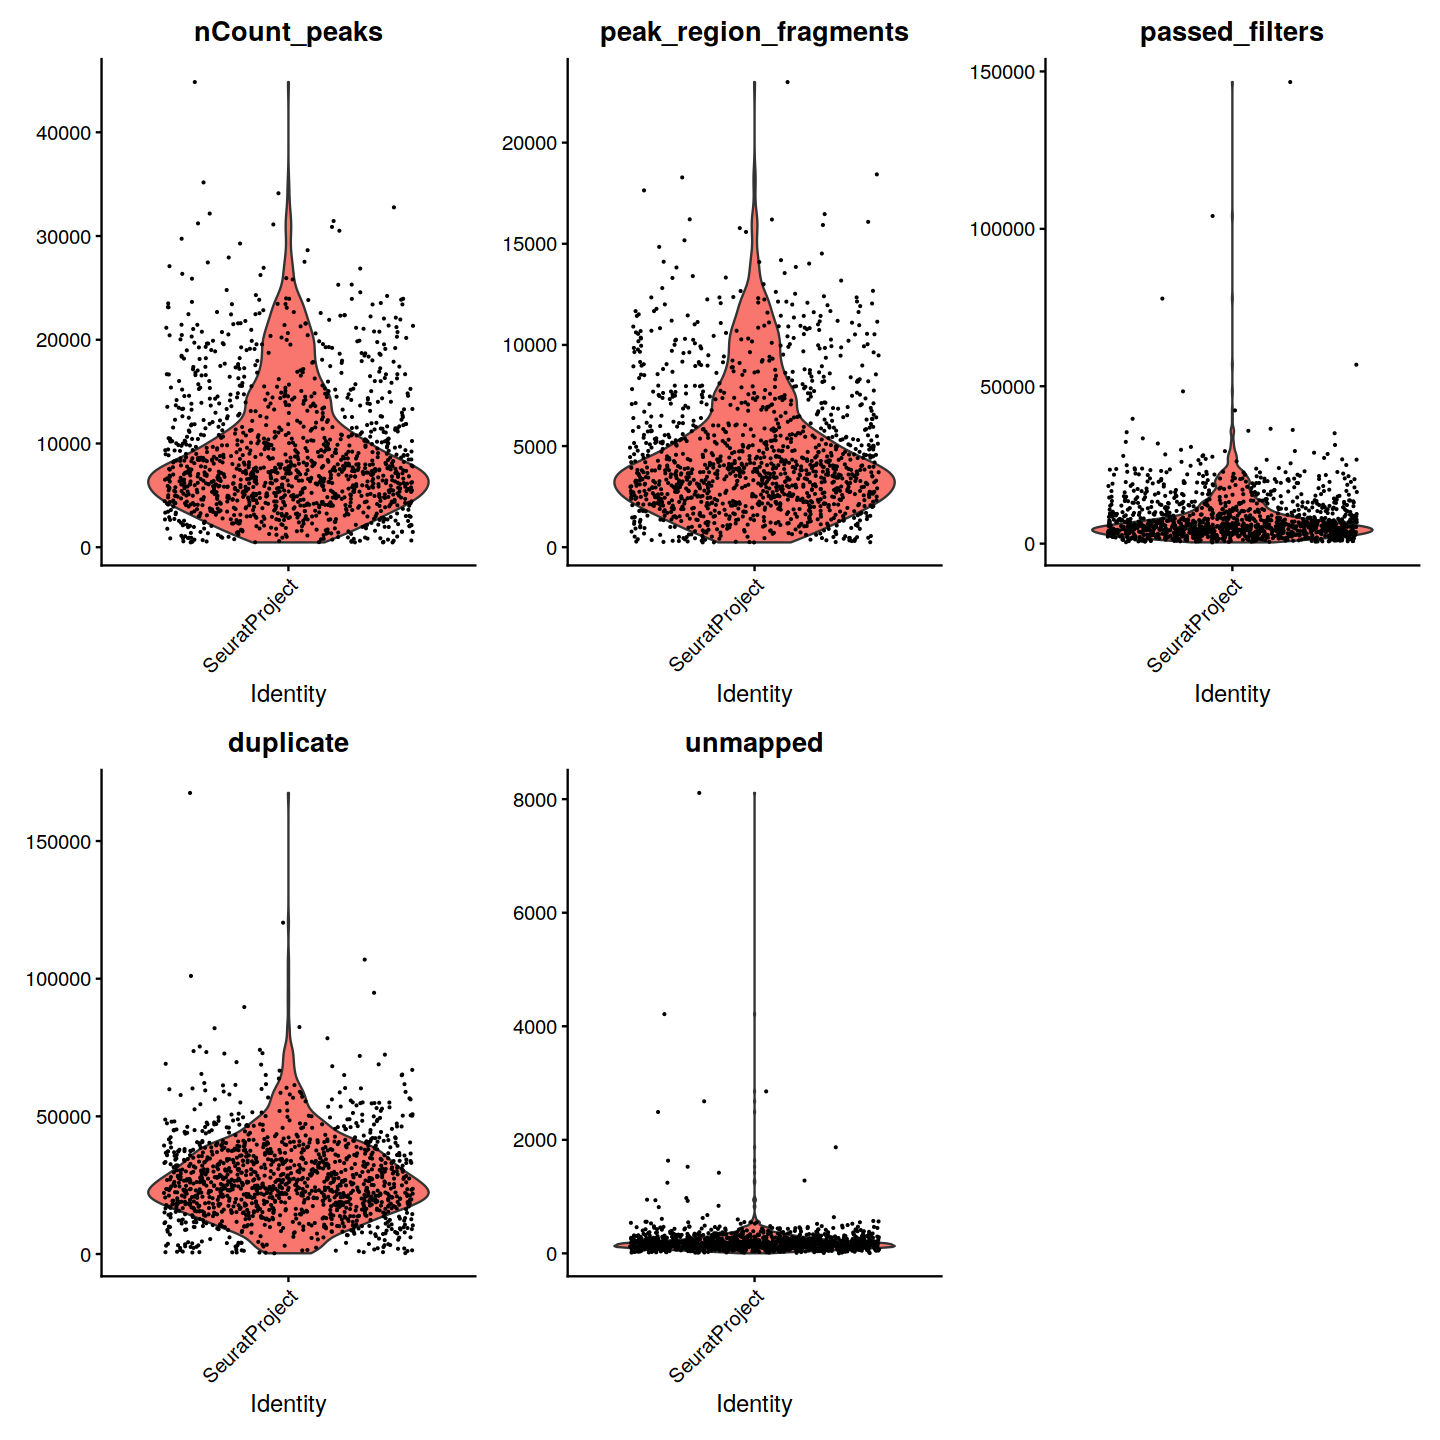

In [16]:
VlnPlot(
  object = se,
  features = c('nCount_peaks', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  pt.size = 0.1,
  ncol = 3
)

## Run for subset

In [17]:
subset(x = se, subset = idents %in% rownames(barcodes))


ERROR: Error in FetchData(object = object, vars = unique(x = expr.char[vars.use]), : None of the requested variables were found: 


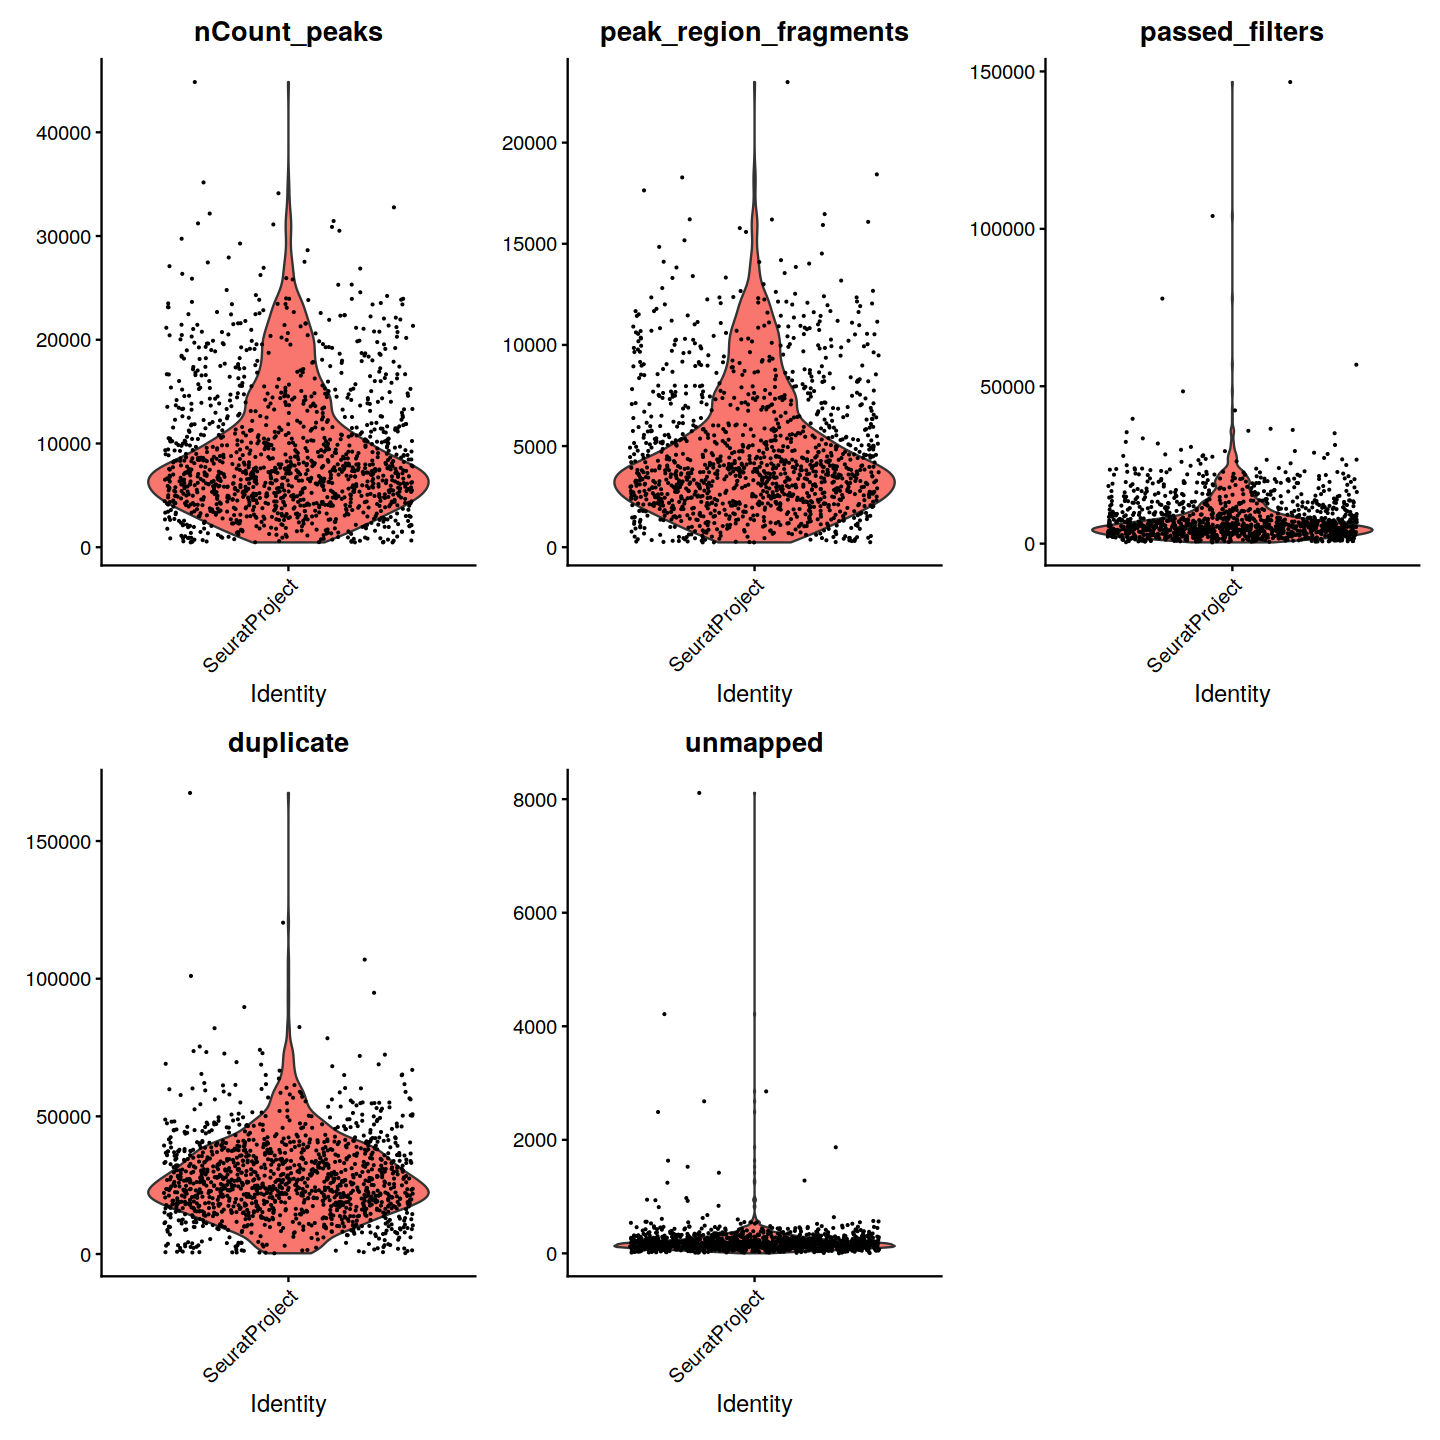

In [16]:
VlnPlot(
  object = se,
  features = c('nCount_peaks', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  pt.size = 0.1,
  ncol = 3
)

In [ ]:
se <- BinarizeCounts(curr)


In [ ]:
se <- RunTFIDF(se)
se <- RunSVD(se)
se <- RunUMAP(se, dims = 2:50, reduction = 'lsi')
DimPlot(se, group.by = "proj", pt.size = 0.1)

## Merge

In [ ]:
# merge all datasets, adding a cell ID to make sure cell names are unique
combined <- merge(
  x = allSE[[1]],
  y = unlist(allSE[2:length(allSE)],use.names=FALSE), #allSE[2:length(allSE)],
  add.cell.ids = sample_names
)
combined[["ATAC"]]



In [ ]:
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined

In [ ]:
combined[[]]

## Filter for low peak counts and low cell counts before dimRed and integrating  
Should cutoffs be data-dependent? empirical? Plot distributions for each

### Plot metadata passed_filters, nCount_ATAC, and duplicates

In [ ]:
FeaturePlot(allSE[[1]])#[[]]

In [ ]:
# perform an initial filtering of low count cells
md.500 <- md.500[md.500$passed_filters > 500, ]
md.1k <- md.1k[md.1k$passed_filters > 500, ]
md.5k <- md.5k[md.5k$passed_filters > 500, ]
md.10k <- md.10k[md.10k$passed_filters > 1000, ] # sequenced deeper so set higher cutoff

## Integrate datasets
### Uses https://satijalab.org/signac/articles/integrate_atac.html

In [ ]:
p1 <- DimPlot(combined, group.by = "proj")

## First break them up again by subsetting, then integrating

In [ ]:
# ext <- subset(x = combined, subset = orig.ident == samples[1])
# curr <- subset(x = combined, subset = orig.ident == samples[2])

allSE <- lapply(samples,  function(x) subset(combined, subset = orig.ident == x))
allSE

In [ ]:
# find integration anchors
integration.anchors <- FindIntegrationAnchors(
  object.list = allSE, #c(ext,curr),
  anchor.features = allSE[[1]], #rownames(ext),
  reduction = "rlsi",
  dims = 2:30
)

# integrate LSI embeddings
integrated <- IntegrateEmbeddings(
  anchorset = integration.anchors,
  reductions = combined[["lsi"]],
  new.reduction.name = "integrated_lsi",
  dims.to.integrate = 1:30
)



In [ ]:
# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "proj")

In [ ]:
pDepthCorr <- DepthCor(integrated)

In [ ]:

(p1 + ggtitle("Merged")) | (p2 + ggtitle("Integrated"))
ggsave(file.path(outdir,"integrated.merged.compare.png"))

In [ ]:
p2
ggsave(file.path(outdir,"integrated.batch.png"))

In [ ]:
pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()
pclust

## Plot new cluster results

In [ ]:
#integrated <- RunUMAP(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindNeighbors(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindClusters(object = integrated, verbose = FALSE, algorithm = 3)


In [ ]:
pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()
ggsave(file.path(outdir, "integrated.lsi.clusters.png"), pclust)
pclust

In [ ]:
pdepth <- DimPlot(object = integrated, label = TRUE, group.by="nFeature_RNA")#, shape.by="nFeature_RNA") 
pdepth


In [ ]:
## ATAC DE peaks

# # change back to working with peaks instead of gene activities
# DefaultAssay(integrated) <- 'ATAC'

# da_peaks <- FindMarkers(
#   object = integrated,
#   ident.1 = 9, #"CD4 Naive",
#   min.pct = 0.05,
#   test.use = 'LR',
#   #latent.vars = 'peak_region_fragments'
# )


# plot1 <- VlnPlot(
#   object = integrated,
#   features = rownames(da_peaks)[1],
#   pt.size = 0.1,
#   idents = c(1,9)
# )
# plot2 <- FeaturePlot(
#   object = integrated,
#   features = rownames(da_peaks)[1],
#   pt.size = 0.1
# )

# plot1 | plot2


## Get gene activity results and run DE results for RNA

In [ ]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# change to UCSC style since the data was mapped to hg19
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"

# add the gene information to the object
Annotation(integrated) <- annotations


gene.activities <- GeneActivity(integrated)


In [ ]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
integrated[['RNA']] <- CreateAssayObject(counts = gene.activities)
integrated <- NormalizeData(
  object = integrated,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(integrated$nCount_RNA)
)

In [ ]:
DefaultAssay(integrated) <- 'RNA'

In [ ]:
saveRDS(integrated, file.path(outdir, paste0("allSamples.integrated.rds")))

## Compute DE for each cluster

In [ ]:
plotDE <- function(integrated, de.results, i, outdir){
    try
    {
    plot1 <- VlnPlot(
      object = integrated,
      features = rownames(de.results)[1],
      pt.size = 0.1,
      idents = i
    )
    plot2 <- FeaturePlot(
      object = integrated,
      features = rownames(de.results)[1],
      pt.size = 0.1
    )

    plot3 <- FeaturePlot(
      object = integrated,
      features = rownames(de.results)[2],
      pt.size = 0.1
    )
    
    plot1 | plot2 | plot3
    
    ggsave(file.path(outdir,paste0("cluster_",i,".DE.GeneActivity.top2Genes.png")))
    
    return(c(plot1, plot2, plot3))
    }
    return
}

## Loop through each cluster and run DA for RNA-seq

In [ ]:
cluster.ids <- sort(unique(Idents(integrated)))

In [ ]:
de.results <- function(i){
    print(paste("cluster", i))
    da.peaks <- FindMarkers(
                  object = integrated,
                  ident.1 = i, #"CD4 Naive",
                  min.pct = 0.1,
                  test.use = 'LR',
                )
    colnames(da.peaks) <- lapply(colnames(da.peaks), function(x) paste0("cluster", i, "__", x))
    da.peaks$gene = rownames(da.peaks)
    #write.csv(da.peaks, file=file.path(outdir,paste0("cluster_",i,".DE.GeneActivity.csv")))
    #print(paste('saved cluster', x))
    #p_out <- plotDE(integrated, da.peaks, x, outdir)
    #all.plotDE <- c(all.plotDE, p_out)
    #print(paste('plotted cluster', x))    
    return(da.peaks)
}
                                 
all.da <- lapply(cluster.ids, function(x) de.results(x))
all.da <- plyr::join_all(all.da, by="gene")
write.csv(all.da, file=file.path(outdir,"allCluster.DE.GeneActivity.csv"))

In [ ]:
# cluster.ids <- sort(unique(Idents(integrated)))

# all.da = data.frame(rownames=rownames(integrated))
# all.plotDE = c()
# for (i in cluster.ids){ #or however many clusters you have
# try({
#     print(paste("cluster", i))
#     da.peaks <- FindMarkers(
#                   object = integrated,
#                   ident.1 = i, #"CD4 Naive",
#                   min.pct = 0.1,
#                   test.use = 'LR',
#                 )
#     colnames(da.peaks) <- lapply(colnames(da.peaks), function(x) paste0("cluster", i, "__", x))
#     all.da = full_join(all.da, da.peaks)
#     #write.csv(da.peaks, file=file.path(outdir,paste0("cluster_",i,".DE.GeneActivity.csv")))
#     print(paste('saved cluster', i))

#     p_out <- plotDE(integrated, da.peaks, i, outdir)
#     all.plotDE <- c(all.plotDE, p_out)
#     print(paste('plotted cluster', i))
    
# })
# }

## Dotplots for clusters

### First feature plots

### Immune markers taken from Seurat

In [ ]:
FeaturePlot(integrated, features = c("CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", 
    "CCL2", "PPBP"), min.cutoff = "q9")
ggsave(file.path(outdir,"lin.ImmuneGenes.umap.png"))

In [ ]:
markers.to.plot <- c("CD3D", "CREM", "HSPH1", "SELL", "GIMAP5", "CACYBP", "GNLY", "NKG7", "CCL5", 
    "CD8A", "MS4A1", "CD79A", "MIR155HG", "NME1", "FCGR3A", "VMO1", "CCL2", "S100A9", "HLA-DQA1", 
    "GPR183", "PPBP", "GNG11", "HBA2", "HBB", "TSPAN13", "IL3RA", "IGJ")
DotPlot(integrated, features = rev(markers.to.plot), cols = c("blue", "red"), dot.scale = 8, 
    split.by = "orig.ident") + RotatedAxis()

ggsave(file.path(outdir,"lin.ImmuneGenes.dot.png"))

### Immune markers taken from Dawn Lin et al Flt3l paper

In [ ]:
immune.markers = c('KIT',
                   'LY6E',
                   'ITGAX',
                   'SLAMF1',
                   'CD34',
                   'FCGR3A',
                   'PTPRC',
                   'SLAMF2',
                   'IL7R',
                   'ITGAM')

DotPlot(integrated, features = rev(immune.markers), cols = c("blue", "red"), dot.scale = 8, 
    split.by = "orig.ident") + RotatedAxis()
ggsave(file.path(outdir,"seurat.ImmuneGenes.dot.png"))

In [ ]:
FeaturePlot(integrated, features = immune.markers, min.cutoff = "q9")

## Conserved markers to help idenify cell type

In [ ]:
# cluster.ids <- sort(unique(Idents(integrated)))
# topMarkers = c()
# for (i in cluster.ids){ #or however many clusters you have
# try({
#     print(paste("cluster", i))
#     cons.markers <- FindConservedMarkers(integrated, ident.1 = i, 
#                                          grouping.var = "orig.ident", verbose = TRUE)

#     write.csv(cons.markers, file=file.path(outdir,paste0("cluster_",i,".conservedOverStim.GeneActivity.csv")))
#     print(paste('saved cluster', i))
#     print(head(cons.markers))
#     topMarkers = c(topMarkers, rownames(cons.markers)[1])
#     print(topMarkers)
# })
# }

# head(cons.markers)

In [ ]:
# theme_set(theme_cowplot())
# t.cells <- subset(integrated, idents = 9)#"CD4 Naive T")
# Idents(t.cells) <- "orig.ident"
# avg.t.cells <- data.frame(log1p(AverageExpression(t.cells, verbose = FALSE)$RNA))
# rownames(avg.t.cells) <- rownames(t.cells) #avg.t.cells$gene <- rownames(avg.t.cells)

# cd14.mono <- subset(integrated, idents = 2)
# Idents(cd14.mono) <- "orig.ident"
# avg.cd14.mono <- data.frame(log1p(AverageExpression(cd14.mono, verbose = FALSE)$RNA))
# rownames(avg.cd14.mono) <- rownames(cd14.mono) #$gene <- rownames(avg.cd14.mono)

In [ ]:
# genes.to.label = c("ISG15", "LY6E", "IFI6", "ISG20", "MX1", "IFIT2", "IFIT1", "CXCL10", "CCL8")
# p1 <- ggplot(avg.t.cells, aes_string(samples[[1]], samples[[2]])) + geom_point() + ggtitle("Cluster 9")
# p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE, xnudge=0, ynudge=0)
# p2 <- ggplot(avg.cd14.mono, aes_string(samples[[1]], samples[[2]])) + geom_point() + ggtitle("Cluster 2")
# p2 <- LabelPoints(plot = p2, points = genes.to.label, repel = TRUE)
# plot_grid(p1, p2)

In [ ]:
sessionInfo()